# Packages

In [1]:
import geopandas as gpd
from matplotlib import pyplot as plt
from matplotlib import cm
import networkx as nx
import numpy as np
import os
import pandas as pd
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from folders import *

plt.style.use("seaborn")

# Directory

In [2]:
path = r"C:\Users\jigon\OneDrive\Documentos\Economía\Commuting-Zones-Costa-Rica"
os.chdir(path)

# Read the data

In [3]:
census2011 = pd.read_spss(census2011_file)
costa_rica_map = gpd.read_file(costa_rica_shapefile)
municipalities_coordinates = pd.read_excel(region_concordance_file, sheet_name="base")
region_concordance = pd.read_excel(region_concordance_file, sheet_name="equivalencias region")
municipalities_concordance = pd.read_excel(region_concordance_file, sheet_name="equivalencias canton")
province_concordance = pd.read_excel(region_concordance_file, sheet_name="equivalencias provincia")
map_concordance = pd.read_excel(region_concordance_file, sheet_name="equivalencias mapa")

# Employed population by municipality

In [4]:
employed_pop_df = census2011[census2011["P21_TRABAJO_SEMANA_PASADA"] == "... trabajó durante una hora o más (sin contar los oficios domésticos en su hogar)"]
employed_pop_df = employed_pop_df[["ID_PC", "P29B_CODIGO_UBICACION_TRABAJO"]].copy() 
employed_pop = (employed_pop_df["ID_PC"].value_counts(dropna=True) * 10).to_frame(name="employment")
employed_pop.index.name = "municipality"
employed_pop

,employment
municipality,
San José,107080
Alajuela,90850
Desamparados,78740
Cartago,52990
San Carlos,52770
...,...
Nandayure,2770
Dota,2410
Hojancha,2200


In [5]:
min_employment_pop = pd.merge(employed_pop.reset_index(), employed_pop.reset_index(), how="cross")
min_employment_pop = min_employment_pop.set_index(["municipality_x", "municipality_y"])
min_employment_pop["min_employment_pop"] = min_employment_pop[['employment_x','employment_y']].min(axis=1)
min_employment_pop.drop(columns=["employment_x", "employment_y"], inplace=True)
min_employment_pop = min_employment_pop.unstack()
min_employment_pop

min_employment_pop                                     \
municipality_y               Abangares Acosta Aguirre Alajuela Alajuelita   
municipality_x                                                              
Abangares                         4950   4950    4950     4950       4950   
Acosta                            4950   6660    6660     6660       6660   
Aguirre                           4950   6660    8910     8910       8910   
Alajuela                          4950   6660    8910    90850      25890   
Alajuelita                        4950   6660    8910    25890      25890   
...                                ...    ...     ...      ...        ...   
Turrubares                        1780   1780    1780     1780       1780   
Upala                             4950   6660    8910     9960       9960   
Valverde Vega                     4950   6120    6120     6120       6120   
Vázquez de Coronado               4950   6660    8910    23570      23570   
Zarcero                           4540   4540    4540     4540       4540   

                                                           ...            \
municipality_y      Alvarado Aserrí Atenas Bagaces  Barva  ... Talamanca   
municipality_x                                             ...             
Abangares               4950   4950   4950    4950   4950  ...      4950   
Acosta                  5190   6660   6660    5230   6660  ...      6660   
Aguirre                 5190   8910   8700    5230   8910  ...      7570   
Alajuela                5190  19400   8700    5230  15820  ...      7570   
Alajuelita              5190  19400   8700    5230  15820  ...      7570   
...                      ...    ...    ...     ...    ...  ...       ...   
Turrubares              1780   1780   1780    1780   1780  ...      1780   
Upala                   5190   9960   8700    5230   9960  ...      7570   
Valverde Vega           5190   6120   6120    5230   6120  ...      6120   
Vázquez de Coronado     5190  19400   8700    5230  15820  ...      7570   
Zarcero                 4540   4540   4540    4540   4540  ...      4540   

                                                                       \
municipality_y      Tarrazú  Tibás Tilarán Turrialba Turrubares Upala   
municipality_x                                                          
Abangares              4950   4950    4950      4950       1780  4950   
Acosta                 5390   6660    6050      6660       1780  6660   
Aguirre                5390   8910    6050      8910       1780  8910   
Alajuela               5390  25880    6050     21400       1780  9960   
Alajuelita             5390  25880    6050     21400       1780  9960   
...                     ...    ...     ...       ...        ...   ...   
Turrubares             1780   1780    1780      1780       1780  1780   
Upala                  5390   9960    6050      9960       1780  9960   
Valverde Vega          5390   6120    6050      6120       1780  6120   
Vázquez de Coronado    5390  23570    6050     21400       1780  9960   
Zarcero                4540   4540    4540      4540       1780  4540   

                                                               
municipality_y      Valverde Vega Vázquez de Coronado Zarcero  
municipality_x                                                 
Abangares                    4950                4950    4540  
Acosta                       6120                6660    4540  
Aguirre                      6120                8910    4540  
Alajuela                     6120               23570    4540  
Alajuelita                   6120               23570    4540  
...                           ...                 ...     ...  
Turrubares                   1780                1780    1780  
Upala                        6120                9960    4540  
Valverde Vega                6120                6120    4540  
Vázquez de Coronado          6120               23570    4540  
Zarcero              

# Commuting flows

In [6]:
commuting_flows = employed_pop_df[["ID_PC", "P29B_CODIGO_UBICACION_TRABAJO"]].value_counts(dropna=True).to_frame(name="commuting_flow") * 10
commuting_flows.index.names = ['origin', 'destination']
commuting_flows = commuting_flows.reset_index()
commuting_flows.loc[(commuting_flows['origin'] == commuting_flows['destination']), "commuting_flow"] = 0
commuting_flows = commuting_flows.sort_values(by="commuting_flow", ascending=False)
commuting_flows

,origin,destination,commuting_flow
9,Desamparados,San José,23020
23,Goicoechea,San José,10920
31,La Unión,San José,9550
32,Heredia,San José,9340
33,Alajuela,San José,9310
...,...,...,...
71,Poás,Poás,0
74,Belén,Belén,0
75,Tarrazú,Tarrazú,0
76,Valverde Vega,Valverde Vega,0


## Create commuting matrix

In [7]:
commuting_network = nx.from_pandas_edgelist(commuting_flows, source="origin", target="destination", edge_attr=["commuting_flow"], create_using=nx.DiGraph())
commuting_graph = nx.DiGraph()
commuting_graph.add_nodes_from(sorted(commuting_network.nodes(data=True)))
commuting_graph.add_edges_from(commuting_network.edges(data=True))

In [8]:
commuting_matrix = nx.to_pandas_adjacency(commuting_graph, weight="commuting_flow")

# Calculate distance matrix

In [9]:
# correct column names
min_employment_pop.index = commuting_matrix.columns
min_employment_pop.columns = commuting_matrix.columns

## Adachi et al. (2020) measure
$$D_{ij} = \begin{cases}
    \max \left\{ \varepsilon, 1 - \frac{f_{ij} + f_{ji}}{\min(p_i, p_j)} \right\}, & \text{for } i \neq j \\
    0, & \text{for } i = j
  \end{cases} $$

where $f_{ij}$ is the number of commuters from residence $i$ to workplace $j$, $p_{i}$ is employed population of $i$, and $\varepsilon$ is an arbitrarily small value. Let $\bar{D} = 0.975$ be the threshold where we commuting zones' groups. 

In [10]:
ε = 0.001
threshold = 0.975 # we deviate a bit from Adachi et al. (0.98), since Guanaste should be split in at least two commuting zones. 
D_ij = (commuting_matrix + commuting_matrix.T) / min_employment_pop
D_ij = D_ij.applymap(lambda x: np.maximum(ε, 1 - x))
D_ij.values[[np.arange(D_ij.shape[0])] * 2] = 0 # set diagonal to 0 again
D_ij

C:\Users\jigon\AppData\Local\Temp\ipykernel_34204\694742819.py:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  D_ij.values[[np.arange(D_ij.shape[0])] * 2] = 0 # set diagonal to 0 again


,Abangares,Acosta,Aguirre,Alajuela,Alajuelita,Alvarado,Aserrí,Atenas,Bagaces,Barva,...,Talamanca,Tarrazú,Tibás,Tilarán,Turrialba,Turrubares,Upala,Valverde Vega,Vázquez de Coronado,Zarcero
Abangares,0.000000,1.000000,1.000000,0.993939,1.000000,1.0,1.000000,1.000000,0.997980,1.000000,...,1.000000,0.997980,1.000000,0.995960,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Acosta,1.000000,0.000000,1.000000,0.969970,0.996997,1.0,0.945946,1.000000,1.000000,1.000000,...,1.000000,1.000000,0.993994,1.000000,1.000000,1.000000,0.998498,1.000000,1.000000,1.000000
Aguirre,1.000000,1.000000,0.000000,0.998878,1.000000,1.0,0.998878,1.000000,1.000000,1.000000,...,1.000000,0.998145,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Alajuela,0.993939,0.969970,0.998878,0.000000,0.986868,1.0,0.985567,0.852874,1.000000,0.958913,...,0.996037,0.998145,0.969861,0.998347,0.994860,0.977528,0.991968,0.967320,0.985999,0.969163
Alajuelita,1.000000,0.996997,1.000000,0.986868,0.000000,1.0,0.993814,1.000000,1.000000,0.994311,...,1.000000,1.000000,0.978362,1.000000,0.999065,1.000000,1.000000,1.000000,0.998303,0.997797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Turrubares,1.000000,1.000000,1.000000,0.977528,1.000000,1.0,1.000000,0.988764,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
Upala,1.000000,0.998498,1.000000,0.991968,1.000000,1.0,1.000000,0.998851,0.906310,1.000000,...,1.000000,1.000000,1.000000,0.996694,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
Valverde Vega,1.000000,1.000000,1.000000,0.967320,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.997797
Vázquez de Coronado,1.000000,1.000000,1.000000,0.985999,0.998303,1.0,0.997938,1.000000,0.998088,0.997472,...,0.998679,1.000000,0.968180,1.000000,0.999533,1.000000,1.000000,1.000000,0.000000,1.000000


# Fit model

In [11]:
model = AgglomerativeClustering(n_clusters=None, # don't set a fixed number of clusters
                                affinity='precomputed', # use provided distance measure since we already computed it
                                linkage='average', # average linkage distance as proposed by Adachi et al. (2020)
                                distance_threshold=threshold # Use \bar{D}
)

model = model.fit(D_ij)

# Plot dendogram

In [12]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

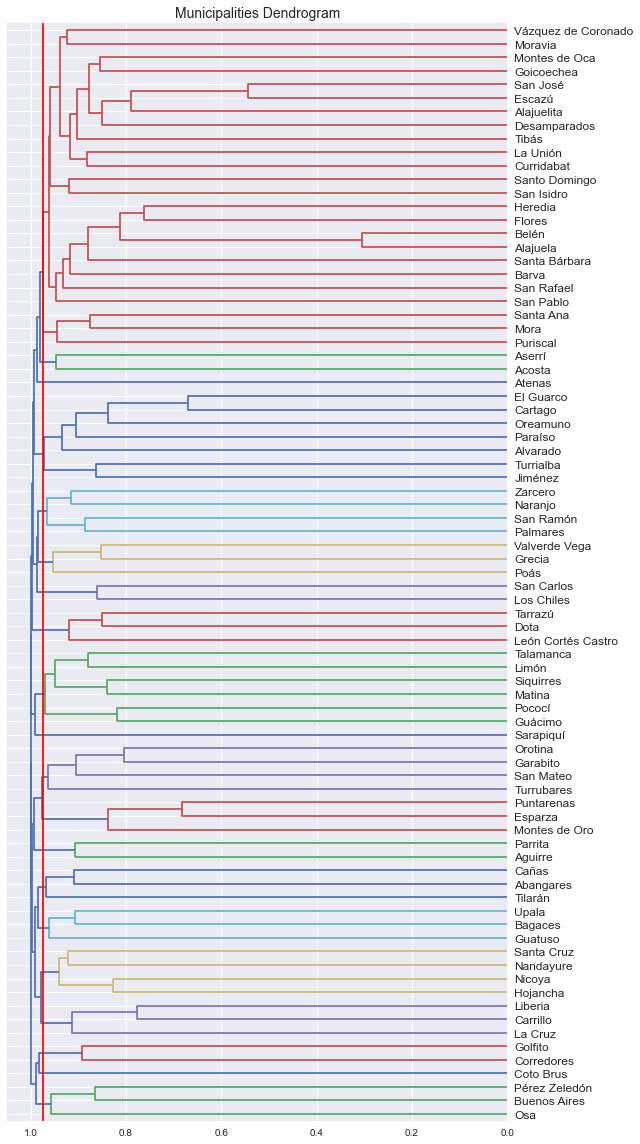

In [13]:
plt.figure(figsize=(9, 16))
plot_dendrogram(model, labels=D_ij.columns, orientation="left", leaf_font_size=12, color_threshold=threshold)
plt.title("Municipalities Dendrogram", size=14)
plt.axvline(threshold, color="r")
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_APPENDIX_OUTPUT, "municipalities_dendogram.png"))
plt.show()

# Commuting zones labeling

In [14]:
czcr_df = pd.DataFrame({"municipality": model.feature_names_in_, "CZ": model.labels_ + 1}).astype("str")
czcr_df

,municipality,CZ
0,Abangares,5
1,Acosta,18
2,Aguirre,16
3,Alajuela,1
4,Alajuelita,1
...,...,...
76,Turrubares,9
77,Upala,7
78,Valverde Vega,8
79,Vázquez de Coronado,1


# Relabel across data sets

## Unique labels from concordance tables (manual elaboration)

In [15]:
region_concordance_names = region_concordance.set_index("enaho_2020").to_dict()["base"]
municipalities_concordance_names = municipalities_concordance.set_index("enaho_2020").to_dict()["base"]
province_concordance_names = province_concordance.set_index("enaho_2020").to_dict()["base"]
map_concordance_names = map_concordance.set_index("shapefile").to_dict()["base"]

## Rename

In [16]:
costa_rica_map["ADM2_ES"] = costa_rica_map["ADM2_ES"].map(map_concordance_names)
costa_rica_map.rename(columns={"ADM2_ES": "municipality"}, inplace=True)
costa_rica_map = costa_rica_map[["municipality", "geometry"]].copy()
czcr_df["municipality"] = czcr_df["municipality"].map(municipalities_concordance_names)
employed_pop = employed_pop.reset_index()
employed_pop["municipality"] = employed_pop["municipality"].map(municipalities_concordance_names)
employed_pop_df.rename(columns={"ID_PC": "municipality_origin", "P29B_CODIGO_UBICACION_TRABAJO": "municipality_destination"}, inplace=True)
employed_pop_df["municipality_origin"] = employed_pop_df["municipality_origin"].map(municipalities_concordance_names)
employed_pop_df["municipality_destination"] = employed_pop_df["municipality_destination"].map(municipalities_concordance_names)

## Merge region groups data sets

In [17]:
costa_rica_map = costa_rica_map.merge(czcr_df, on="municipality", how="left")
costa_rica_map = costa_rica_map.merge(municipalities_coordinates, on="municipality", how="left")
costa_rica_map = costa_rica_map.merge(employed_pop, on="municipality", how="left")
costa_rica_map

,municipality,geometry,CZ,region,province,lat,lon,employment
0,alajuela,"POLYGON ((-84.16105 10.41363, -84.16104 10.332...",1,central,alajuela,10.017556,-84.210179,90850
1,alfaro ruiz,"POLYGON ((-84.43085 10.26836, -84.43057 10.268...",3,central,alajuela,10.185135,-84.392542,4540
2,atenas,"POLYGON ((-84.39104 10.03862, -84.39085 10.038...",13,central,alajuela,9.979428,-84.380373,8700
3,grecia,"MULTIPOLYGON (((-84.26567 10.18160, -84.26483 ...",8,central,alajuela,10.073608,-84.311993,27800
4,guatuso,"POLYGON ((-84.80441 10.85126, -84.80367 10.850...",7,huetar norte,alajuela,10.670350,-84.821398,3990
...,...,...,...,...,...,...,...,...
76,santa ana,"POLYGON ((-84.18970 9.97329, -84.18916 9.97317...",1,central,san jose,9.933400,-84.181074,20150
77,tarrazu,"POLYGON ((-83.97900 9.71809, -83.97867 9.71741...",10,central,san jose,9.658919,-84.021822,5390
78,tibas,"POLYGON ((-84.05597 9.97249, -84.05552 9.97243...",1,central,san jose,9.962682,-84.078478,25880
79,turrubares,"POLYGON ((-84.42320 9.92276, -84.42300 9.92221...",9,central,san jose,9.914063,-84.440839,1780


# Plot commuting zones

In [18]:
n_CZs = costa_rica_map.CZ.nunique()
n_CZs

20

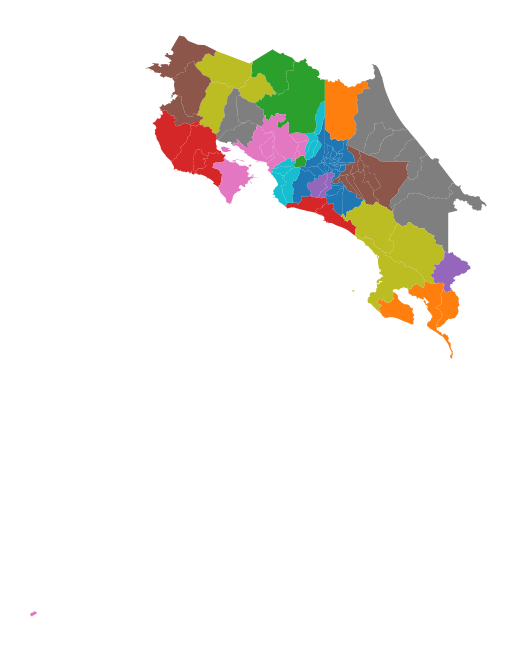

In [19]:
costa_rica_map.plot(column="CZ", figsize=(9, 16))
plt.axis('off')
plt.savefig(os.path.join(FIGURES_MAIN_TEXT_OUTPUT, "CR_CZs_map.png"))

# Save CZs

In [20]:
costa_rica_map.drop(columns=["geometry"], inplace=True)
costa_rica_map.to_excel(costa_rican_commuting_zones_file, index=False)

# Save Census 2011 employment

In [21]:
employed_pop_df.to_excel(employment2011_file, index=False)